<a href="https://colab.research.google.com/github/aldiekawahyu/manajerku-inventory-management/blob/main/demand_forecasting_newdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data
Source: https://www.kaggle.com/c/demand-forecasting-kernels-only/data \\
Steps:
1. Go to kaggle account and click **'Create New API Token'**. A kaggle.json file will be downloaded to your local machine.
1. Upload the kaggle.json file into into colab
1. Download the dataset from kaggle and unzip it

In [323]:
import os

! pip install -q kaggle
from google.colab import files
files.upload()
try:
  os.makedirs('~/.kaggle')    
  print('Directory created successfully')
except:
  pass
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c demand-forecasting-kernels-only
! unzip train.csv.zip

Saving kaggle.json to kaggle (6).json
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


# EDA and Data Preprocessing

## Check Missing Value and Object Type

First, open the csv file as pandas dataframe file then check if there are missing values.

In [324]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('train.csv')
# df_train['is_train'] = np.repeat(True, df_train.shape[0])
print('Train length: {}'.format(len(df_train)))
df_train.head()

Train length: 913000


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [325]:
df_test = pd.read_csv('test.csv')
df_test = df_test.drop('id', axis=1)
df_test['sales'] = np.zeros(df_test.shape[0])
# df_test['is_train'] = np.repeat(False, df_test.shape[0])
print('Test length: {}'.format(len(df_test)))
df_test.head()

Test length: 45000


,date,store,item,sales
0,2018-01-01,1,1,0.0
1,2018-01-02,1,1,0.0
2,2018-01-03,1,1,0.0
3,2018-01-04,1,1,0.0
4,2018-01-05,1,1,0.0


In [326]:
df = pd.concat([df_train, df_test])
print('df length: {}'.format(len(df)))
df.head()


df length: 958000


,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


Check the number of missing value per column.

In [327]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Proportion of missing value per column.

Next, we will check the type of each column of the data.

In [328]:
df.dtypes

date      object
store      int64
item       int64
sales    float64
dtype: object

Altering the type of *date* column to datetime.

In [329]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales           float64
dtype: object

The *date* column is already converted to datetime.

## Get Unique Value of *item* and	*sales*

In [330]:
# Item
items = sorted(df['item'].unique().tolist())
number_of_item = len(items)
print('Number of item: {}'.format(number_of_item))

# Store
stores = sorted(df['store'].unique().tolist())
number_of_store = len(stores)
print('Number of store: {}'.format(number_of_store))

Number of item: 50
Number of store: 10


## Check Total Number of *item* per *store*

In [331]:
item_per_store = df.groupby(['store'])['item'].nunique()
print("Total number of item of each store\n{}".format(item_per_store))

Total number of item of each store
store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


## Check Total Dates (days) per item

In [332]:
days_per_item = df.groupby(['item'])['date'].nunique()
print("Total number of days per item: \n{}".format(days_per_item.tolist()))

Total number of days per item: 
[1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916]


We can see that each product has the same amount of record.

## Inspect the Sales Aggregate of Each Item


In [333]:
df.groupby(["item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
            sum       mean median        std
item                                        
1      401384.0  20.949061   21.0   9.486058
2     1069564.0  55.822756   55.0  23.202639
3      669087.0  34.921033   34.0  15.021552
4      401907.0  20.976357   21.0   9.433774
5      335230.0  17.496347   17.0   8.086540
6     1068281.0  55.755793   55.0  23.262341
7     1068777.0  55.781681   55.0  23.241525
8     1405108.0  73.335491   72.0  30.262644
9      938379.0  48.975939   48.0  20.490318
10    1337133.0  69.787735   69.0  28.763378
11    1271925.0  66.384395   66.0  27.468988
12    1271534.0  66.363987   65.0  27.461558
13    1539621.0  80.356002   79.0  32.895851
14    1071531.0  55.925418   55.0  23.203971
15    1607442.0  83.895720   83.0  34.315986
16     468480.0  24.450939   24.0  10.833233
17     602486.0  31.444990   31.0  13.610058
18    1538876.0  80.317119   79.0  32.989332
19     736892.0  38.459916   38.0  16.391578
20     867641.0  45.283977   45.0  18.979967
21     736190.0  38.423278   38.0  16.391810
22    1469971.0  76.720825   76.0  31.479807
23     534979.0  27.921660   27.0  12.247102
24    1205975.0  62.942328   62.0  26.059538
25    1473334.0  76.896347   76.0  31.599961
26     869981.0  45.406106   45.0  19.187860
27     402628.0  21.013987   21.0   9.486944
28    1604713.0  83.753288   83.0  34.281549
29    1271240.0  66.348643   65.0  27.374897
30     736554.0  38.442276   38.0  16.415119
31    1070845.0  55.889614   55.0  23.220216
32     803107.0  41.915814   41.0  17.826177
33    1270183.0  66.293476   65.0  27.436419
34     469935.0  24.526879   24.0  10.854052
35    1201541.0  62.710908   62.0  25.974665
36    1406548.0  73.410647   73.0  30.219604
37     534258.0  27.884029   27.0  12.202470
38    1470330.0  76.739562   76.0  31.501464
39     801311.0  41.822077   41.0  17.762857
40     534094.0  27.875470   27.0  12.244787
41     401759.0  20.968633   21.0   9.431716
42     669925.0  34.964770   34.0  15.056393
43     936635.0  48.884916   48.0  20.488585
44     536811.0  28.017276   28.0  12.239518
45    1471467.0  76.798904   76.0  31.653709
46    1070764.0  55.885386   55.0  23.315656
47     401781.0  20.969781   20.0   9.446815
48     937703.0  48.940658   48.0  20.562157
49     535663.0  27.957359   27.0  12.297638
50    1203009.0  62.787526   62.0  25.945934

## Pivot Table

In [334]:
import numpy as np
df_pivot = pd.pivot_table(df, values=['sales'], index=['date'],
                    columns=['item', 'store'], aggfunc=np.sum).fillna(0)
df_pivot

sales                          ...                              
item          1                           ...    50                        
store         1     2     3     4     5   ...    6     7     8     9     10
date                                      ...                              
2013-01-01  13.0  12.0  19.0  10.0  11.0  ...  20.0  21.0  45.0  36.0  33.0
2013-01-02  11.0  16.0   8.0  12.0   9.0  ...  23.0  30.0  54.0  44.0  37.0
2013-01-03  14.0  16.0  10.0   8.0  12.0  ...  38.0  20.0  54.0  29.0  46.0
2013-01-04  13.0  20.0  15.0  15.0   8.0  ...  33.0  27.0  52.0  43.0  51.0
2013-01-05  10.0  16.0  22.0  19.0  13.0  ...  33.0  18.0  48.0  53.0  41.0
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
2018-03-27   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2018-03-28   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2018-03-29   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2018-03-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2018-03-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[1916 rows x 500 columns]

## **Feature Dataframe**

In [335]:
df_pivot.columns

MultiIndex([('sales',  1,  1),
            ('sales',  1,  2),
            ('sales',  1,  3),
            ('sales',  1,  4),
            ('sales',  1,  5),
            ('sales',  1,  6),
            ('sales',  1,  7),
            ('sales',  1,  8),
            ('sales',  1,  9),
            ('sales',  1, 10),
            ...
            ('sales', 50,  1),
            ('sales', 50,  2),
            ('sales', 50,  3),
            ('sales', 50,  4),
            ('sales', 50,  5),
            ('sales', 50,  6),
            ('sales', 50,  7),
            ('sales', 50,  8),
            ('sales', 50,  9),
            ('sales', 50, 10)],
           names=[None, 'item', 'store'], length=500)

In [336]:
df_feature = pd.DataFrame(index=df_pivot.index)
for colnames in df_pivot.columns:
  df_feature['item_{}_store_{}_sales'.format(colnames[1], colnames[2])] = df_pivot[colnames[0], colnames[1], colnames[2]]
print(len(df_feature))

1916


We are going to **fill missing dates** (if any) in *df_feature* with zero for every column.

In [337]:
df_feature = df_feature.asfreq('D').fillna(0)
print(len(df_feature))

1916


Check the first and last day.

In [338]:
from datetime import datetime, timedelta
first_date = df_feature.index.min()
last_date = df_feature.index.max()
print('First date: {}'.format(first_date))
print('Last date: {}'.format(last_date))

First date: 2013-01-01 00:00:00
Last date: 2018-03-31 00:00:00


Store the column names into list.

In [339]:
item_store_list = df_feature.columns
item_store_list

Index(['item_1_store_1_sales', 'item_1_store_2_sales', 'item_1_store_3_sales',
       'item_1_store_4_sales', 'item_1_store_5_sales', 'item_1_store_6_sales',
       'item_1_store_7_sales', 'item_1_store_8_sales', 'item_1_store_9_sales',
       'item_1_store_10_sales',
       ...
       'item_50_store_1_sales', 'item_50_store_2_sales',
       'item_50_store_3_sales', 'item_50_store_4_sales',
       'item_50_store_5_sales', 'item_50_store_6_sales',
       'item_50_store_7_sales', 'item_50_store_8_sales',
       'item_50_store_9_sales', 'item_50_store_10_sales'],
      dtype='object', length=500)

## Time Series Plot

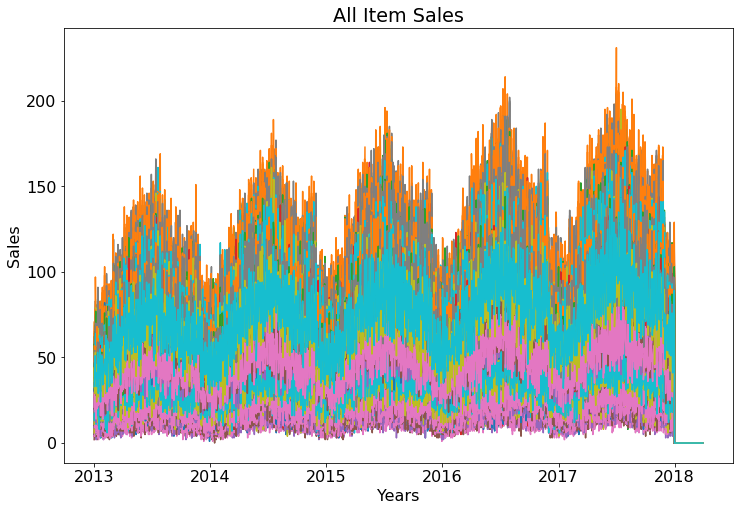

In [340]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(12,8))
for column in df_feature:
    plt.plot(df_feature.index, df_feature[column])
ax.set_title('All Item Sales')
ax.set_xlabel('Years')
ax.set_ylabel('Sales')
plt.show()

Randomly choose 10 series and plot them

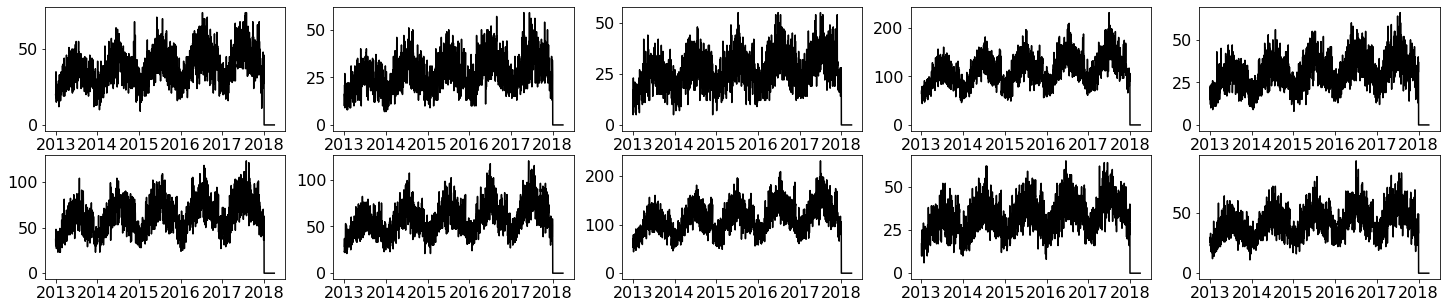

In [341]:
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(25,5))
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].plot(df_feature.index, df_feature.sample(axis='columns').values, c='black')
plt.show()

Adding the *is_train* columns

In [342]:
df_train_pivot = pd.pivot_table(df_train, values=['sales'], index=['date'],
                    columns=['item', 'store'], aggfunc=np.sum).fillna(0)
train_length = len(df_train_pivot)
print(train_length)

1826


In [343]:
df_test_pivot = pd.pivot_table(df_test, values=['sales'], index=['date'],
                    columns=['item', 'store'], aggfunc=np.sum).fillna(0)
test_length = len(df_test_pivot)
print(test_length)

90


In [344]:
boolean_list = [True] * train_length + [False] * test_length
df_feature['is_train'] = boolean_list

## One Hot Encoding for Time Units

In [345]:
df_weekday = pd.get_dummies(df_feature.index.weekday, prefix='weekday')
df_weekday.index = df_feature.index
df_weekday.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,
2013-01-01,0,1,0,0,0,0,0
2013-01-02,0,0,1,0,0,0,0
2013-01-03,0,0,0,1,0,0,0
2013-01-04,0,0,0,0,1,0,0
2013-01-05,0,0,0,0,0,1,0


In [346]:
df_month = pd.get_dummies(df_feature.index.month, prefix='month')
df_month.index =  df_feature.index
df_month.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [347]:
df_feature = pd.concat([df_weekday, df_month, df_feature], axis=1)
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Freq: D
Columns: 520 entries, weekday_0 to is_train
dtypes: bool(1), float64(500), uint8(19)
memory usage: 7.4 MB


## Shift Demand

In [348]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))

def shift_series_in_df(df, days_delta, series_names=[]):
    shifted = pd.DataFrame(index=df.index.copy())
    sign = 'future' if np.sign(days_delta) < 0 else 'past'
    for series_name in series_names:
        shifted['{}_{}_{}'.format(series_name,sign,np.abs(days_delta))] = \
          shift_series(df[series_name], days_delta)
    return shifted
    
def stack_shifted_sales(df, days_delta=90):
    names = item_store_list
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [349]:
df_feature_shifted = stack_shifted_sales(df_feature, days_delta=-1)
df_feature_shifted = df_feature_shifted.dropna()

We are going to make sure stacked and standard demand columns appear in the same order.

In [350]:
sales_columns = [column for column in df_feature_shifted.columns if '_sales' in column and '_sales_' not in column]
stacked_sales_columns = [column for column in df_feature_shifted.columns if '_sales_' in column]
other_columns = [column for column in df_feature_shifted.columns if column not in set(sales_columns) and column not in set(stacked_sales_columns)]

sales_columns = sorted(sales_columns)
stacked_sales_columns = sorted(stacked_sales_columns)

new_columns = other_columns + stacked_sales_columns + sales_columns

In [351]:
df_feature_shifted = df_feature_shifted.reindex(columns=new_columns)

In [352]:
assert df_feature_shifted.isna().any().any() == False

In [353]:
df_feature_shifted

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_train,item_10_store_10_sales_past_1,item_10_store_1_sales_past_1,item_10_store_2_sales_past_1,item_10_store_3_sales_past_1,item_10_store_4_sales_past_1,item_10_store_5_sales_past_1,item_10_store_6_sales_past_1,item_10_store_7_sales_past_1,item_10_store_8_sales_past_1,item_10_store_9_sales_past_1,item_11_store_10_sales_past_1,item_11_store_1_sales_past_1,item_11_store_2_sales_past_1,item_11_store_3_sales_past_1,item_11_store_4_sales_past_1,item_11_store_5_sales_past_1,item_11_store_6_sales_past_1,item_11_store_7_sales_past_1,item_11_store_8_sales_past_1,item_11_store_9_sales_past_1,...,item_6_store_10_sales,item_6_store_1_sales,item_6_store_2_sales,item_6_store_3_sales,item_6_store_4_sales,item_6_store_5_sales,item_6_store_6_sales,item_6_store_7_sales,item_6_store_8_sales,item_6_store_9_sales,item_7_store_10_sales,item_7_store_1_sales,item_7_store_2_sales,item_7_store_3_sales,item_7_store_4_sales,item_7_store_5_sales,item_7_store_6_sales,item_7_store_7_sales,item_7_store_8_sales,item_7_store_9_sales,item_8_store_10_sales,item_8_store_1_sales,item_8_store_2_sales,item_8_store_3_sales,item_8_store_4_sales,item_8_store_5_sales,item_8_store_6_sales,item_8_store_7_sales,item_8_store_8_sales,item_8_store_9_sales,item_9_store_10_sales,item_9_store_1_sales,item_9_store_2_sales,item_9_store_3_sales,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,45.0,37.0,51.0,38.0,30.0,31.0,29.0,25.0,47.0,45.0,49.0,37.0,51.0,37.0,47.0,26.0,26.0,26.0,35.0,35.0,...,32.0,36.0,40.0,38.0,35.0,15.0,27.0,11.0,43.0,33.0,39.0,23.0,47.0,36.0,35.0,16.0,19.0,23.0,29.0,24.0,38.0,37.0,42.0,34.0,44.0,23.0,32.0,32.0,61.0,43.0,23.0,23.0,21.0,16.0,21.0,20.0,17.0,20.0,28.0,36.0
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,50.0,34.0,56.0,60.0,29.0,28.0,26.0,27.0,45.0,42.0,47.0,43.0,56.0,43.0,48.0,21.0,26.0,25.0,44.0,43.0,...,43.0,18.0,41.0,32.0,34.0,37.0,17.0,29.0,39.0,19.0,38.0,34.0,43.0,36.0,31.0,25.0,19.0,25.0,38.0,35.0,37.0,38.0,46.0,61.0,41.0,37.0,36.0,30.0,38.0,34.0,37.0,25.0,29.0,32.0,25.0,15.0,28.0,18.0,31.0,25.0
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,53.0,32.0,46.0,50.0,37.0,23.0,34.0,26.0,46.0,41.0,60.0,34.0,51.0,36.0,58.0,28.0,31.0,26.0,42.0,32.0,...,50.0,19.0,41.0,36.0,42.0,33.0,22.0,18.0,49.0,33.0,33.0,36.0,44.0,38.0,34.0,28.0,14.0,26.0,47.0,35.0,44.0,54.0,55.0,38.0,44.0,39.0,31.0,28.0,56.0,41.0,28.0,22.0,32.0,40.0,37.0,20.0,33.0,24.0,46.0,31.0
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,True,51.0,45.0,56.0,46.0,45.0,32.0,42.0,37.0,62.0,46.0,47.0,52.0,47.0,43.0,47.0,43.0,39.0,33.0,67.0,42.0,...,43.0,31.0,47.0,36.0,41.0,20.0,32.0,16.0,41.0,36.0,46.0,38.0,55.0,31.0,44.0,32.0,26.0,26.0,51.0,28.0,58.0,51.0,64.0,54.0,34.0,37.0,32.0,42.0,60.0,49.0,35.0,29.0,45.0,44.0,37.0,23.0,27.0,14.0,35.0,30.0
2013-01-06,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,True,54.0,35.0,53.0,46.0,52.0,30.0,45.0,31.0,51.0,52.0,31.0,45.0,62.0,43.0,49.0,25.0,33.0,34.0,50.0,45.0,...,47.0,31.0,42.0,37.0,55.0,21.0,30.0,19.0,38.0,55.0,40.0,32.0,46.0,35.0,33.0,28.0,31.0,26.0,41.0,30.0,42.0,60.0,66.0,64.0,57.0,47.0,31.0,42.0,61.0,51.0,37.0,35.0,41.0,34.0,37.0,29.0,20.0,24.0,34.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [354]:
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = [column for column in df_feature_shifted.columns if 'weekday' not in column and 'month' not in column]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_cols = scaler.fit_transform(df_feature_shifted[columns_to_scale])
df_feature_shifted[columns_to_scale] = scaled_cols

In [355]:
df_feature_shifted

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_train,item_10_store_10_sales_past_1,item_10_store_1_sales_past_1,item_10_store_2_sales_past_1,item_10_store_3_sales_past_1,item_10_store_4_sales_past_1,item_10_store_5_sales_past_1,item_10_store_6_sales_past_1,item_10_store_7_sales_past_1,item_10_store_8_sales_past_1,item_10_store_9_sales_past_1,item_11_store_10_sales_past_1,item_11_store_1_sales_past_1,item_11_store_2_sales_past_1,item_11_store_3_sales_past_1,item_11_store_4_sales_past_1,item_11_store_5_sales_past_1,item_11_store_6_sales_past_1,item_11_store_7_sales_past_1,item_11_store_8_sales_past_1,item_11_store_9_sales_past_1,...,item_6_store_10_sales,item_6_store_1_sales,item_6_store_2_sales,item_6_store_3_sales,item_6_store_4_sales,item_6_store_5_sales,item_6_store_6_sales,item_6_store_7_sales,item_6_store_8_sales,item_6_store_9_sales,item_7_store_10_sales,item_7_store_1_sales,item_7_store_2_sales,item_7_store_3_sales,item_7_store_4_sales,item_7_store_5_sales,item_7_store_6_sales,item_7_store_7_sales,item_7_store_8_sales,item_7_store_9_sales,item_8_store_10_sales,item_8_store_1_sales,item_8_store_2_sales,item_8_store_3_sales,item_8_store_4_sales,item_8_store_5_sales,item_8_store_6_sales,item_8_store_7_sales,item_8_store_8_sales,item_8_store_9_sales,item_9_store_10_sales,item_9_store_1_sales,item_9_store_2_sales,item_9_store_3_sales,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.288462,0.282443,0.291429,0.240506,0.194805,0.269565,0.252174,0.25,0.270115,0.304054,0.335616,0.298387,0.305389,0.218935,0.324138,0.238532,0.245283,0.262626,0.205882,0.255474,...,0.237037,0.346154,0.270270,0.279412,0.309735,0.154639,0.303371,0.135802,0.307143,0.264,0.302326,0.200000,0.338129,0.292683,0.299145,0.163265,0.202128,0.273810,0.205674,0.201681,0.224852,0.270073,0.232044,0.191011,0.283871,0.191667,0.280702,0.299065,0.346591,0.272152,0.191667,0.244681,0.165354,0.148148,0.189189,0.238095,0.209877,0.256410,0.208955,0.327273
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.320513,0.259542,0.320000,0.379747,0.188312,0.243478,0.226087,0.27,0.258621,0.283784,0.321918,0.346774,0.335329,0.254438,0.331034,0.192661,0.245283,0.252525,0.258824,0.313869,...,0.318519,0.173077,0.277027,0.235294,0.300885,0.381443,0.191011,0.358025,0.278571,0.152,0.294574,0.295652,0.309353,0.292683,0.264957,0.255102,0.202128,0.297619,0.269504,0.294118,0.218935,0.277372,0.254144,0.342697,0.264516,0.308333,0.315789,0.280374,0.215909,0.215190,0.308333,0.265957,0.228346,0.296296,0.225225,0.178571,0.345679,0.230769,0.231343,0.227273
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.339744,0.244275,0.262857,0.316456,0.240260,0.200000,0.295652,0.26,0.264368,0.277027,0.410959,0.274194,0.305389,0.213018,0.400000,0.256881,0.292453,0.262626,0.247059,0.233577,...,0.370370,0.182692,0.277027,0.264706,0.371681,0.340206,0.247191,0.222222,0.350000,0.264,0.255814,0.313043,0.316547,0.308943,0.290598,0.285714,0.148936,0.309524,0.333333,0.294118,0.260355,0.394161,0.303867,0.213483,0.283871,0.325000,0.271930,0.261682,0.318182,0.259494,0.233333,0.234043,0.251969,0.370370,0.333333,0.238095,0.407407,0.307692,0.343284,0.281818
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.326923,0.343511,0.320000,0.291139,0.292208,0.278261,0.365217,0.37,0.356322,0.310811,0.321918,0.419355,0.281437,0.254438,0.324138,0.394495,0.367925,0.333333,0.394118,0.306569,...,0.318519,0.298077,0.317568,0.264706,0.362832,0.206186,0.359551,0.197531,0.292857,0.288,0.356589,0.330435,0.395683,0.252033,0.376068,0.326531,0.276596,0.309524,0.361702,0.235294,0.343195,0.372263,0.353591,0.303371,0.219355,0.308333,0.280702,0.392523,0.340909,0.310127,0.291667,0.308511,0.354331,0.407407

In [356]:
# df_feature_shifted.to_csv('df_feature_shifted.csv')

## Get Training and Validation Dataframe

In [357]:
df_train = df_feature_shifted[df_feature_shifted['is_train'] == True].drop('is_train', axis=1)
df_test = df_feature_shifted[df_feature_shifted['is_train'] == False].drop('is_train', axis=1)

Next we are going to extract the "X" and "y" for training

In [358]:
X_columns_stacked = [column for column in df_train.columns if '_past_' in column]
X_columns_caldata = [column for column in df_train.columns if 'weekday' in column or 'month' in column]
X_columns = X_columns_stacked + X_columns_caldata

X = df_train[X_columns]

In [359]:
X_colset = set(X_columns)
y_columns = [column for column in df_train.columns if column not in X_colset]

y = df_train[y_columns]

Train test split

In [360]:
test_size = 0.2
training_size = 1 - test_size

X_train = X.iloc[:int(training_size*len(X))].copy()
X_valid = X.iloc[int(training_size*len(X)):].copy()
y_train = y.iloc[:int(training_size*len(y))].copy()
y_valid = y.iloc[int(training_size*len(y)):].copy()

Reshaping the variable for multivariate time series training.

In [361]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [362]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Freq: D
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [363]:
len(y.columns)

500

# Modeling and Forecasting

## Define the Model

In [364]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.__version__

'2.5.0'

In [365]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
    tf.keras.layers.LSTM(len(y.columns), return_sequences=True),    
    tf.keras.layers.Dense(len(y.columns), activation='relu'),
    tf.keras.layers.Dense(len(y.columns), activation='relu'),
    tf.keras.layers.Conv1D(
        filters=len(y.columns),
        kernel_size=1,
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
    tf.keras.layers.Conv1D(
        filters=2*len(y.columns),
        kernel_size=50,
        padding='same',
        activation='relu'),
    tf.keras.layers.Conv1D(
        filters=len(y.columns),
        kernel_size=10,
        padding='same',
        activation='relu'),
    tf.keras.layers.AvgPool1D(
        pool_size=10, 
        padding='same'),
    tf.keras.layers.LSTM(len(y.columns), dropout=0.2),    
    tf.keras.layers.Dense(len(y.columns))
])
"""

"\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.InputLayer(\n        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),\n    tf.keras.layers.LSTM(len(y.columns), return_sequences=True),    \n    tf.keras.layers.Dense(len(y.columns), activation='relu'),\n    tf.keras.layers.Dense(len(y.columns), activation='relu'),\n    tf.keras.layers.Conv1D(\n        filters=len(y.columns),\n        kernel_size=1,\n        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),\n    tf.keras.layers.Conv1D(\n        filters=2*len(y.columns),\n        kernel_size=50,\n        padding='same',\n        activation='relu'),\n    tf.keras.layers.Conv1D(\n        filters=len(y.columns),\n        kernel_size=10,\n        padding='same',\n        activation='relu'),\n    tf.keras.layers.AvgPool1D(\n        pool_size=10, \n        padding='same'),\n    tf.keras.layers.LSTM(len(y.columns), dropout=0.2),    \n    tf.keras.layers.Dense(len(y.columns))\n])\n"

In [366]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),    
    tf.keras.layers.Conv1D(
        filters=len(y.columns),
        kernel_size=1,
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
    tf.keras.layers.Conv1D(
        filters=2*len(y.columns),
        kernel_size=50,
        padding='same',
        activation='relu'),
    tf.keras.layers.Conv1D(
        filters=len(y.columns),
        kernel_size=10,
        padding='same',
        activation='relu'),
    tf.keras.layers.AvgPool1D(
        pool_size=10, 
        padding='same'),
    tf.keras.layers.LSTM(len(y.columns), dropout=0.2),    
    tf.keras.layers.Dense(len(y.columns)),
    tf.keras.layers.Dense(len(y.columns))
])

In [367]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 500)            260000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 1000)           25001000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 500)            5000500   
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 500)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 500)               2002000   
_________________________________________________________________
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               2

In [368]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=["mape"])

## Training

In [369]:
history = model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=80,
    batch_size=64,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False,
    callbacks=[lr_schedule]
)

Epoch 1/80
23/23 - 3s - loss: 0.4734 - mape: 103.3215 - val_loss: 0.5500 - val_mape: 99.9820
Epoch 2/80
23/23 - 1s - loss: 0.4734 - mape: 104.4213 - val_loss: 0.5500 - val_mape: 99.9816
Epoch 3/80
23/23 - 1s - loss: 0.4734 - mape: 103.3863 - val_loss: 0.5500 - val_mape: 99.9811
Epoch 4/80
23/23 - 1s - loss: 0.4734 - mape: 103.0475 - val_loss: 0.5500 - val_mape: 99.9805
Epoch 5/80
23/23 - 1s - loss: 0.4734 - mape: 102.1609 - val_loss: 0.5500 - val_mape: 99.9798
Epoch 6/80
23/23 - 1s - loss: 0.4734 - mape: 104.2636 - val_loss: 0.5500 - val_mape: 99.9791
Epoch 7/80
23/23 - 1s - loss: 0.4734 - mape: 102.8329 - val_loss: 0.5500 - val_mape: 99.9782
Epoch 8/80
23/23 - 1s - loss: 0.4734 - mape: 103.0577 - val_loss: 0.5500 - val_mape: 99.9773
Epoch 9/80
23/23 - 1s - loss: 0.4734 - mape: 102.7938 - val_loss: 0.5500 - val_mape: 99.9762
Epoch 10/80
23/23 - 1s - loss: 0.4734 - mape: 102.1726 - val_loss: 0.5500 - val_mape: 99.9751
Epoch 11/80
23/23 - 1s - loss: 0.4734 - mape: 103.4010 - val_loss: 0.

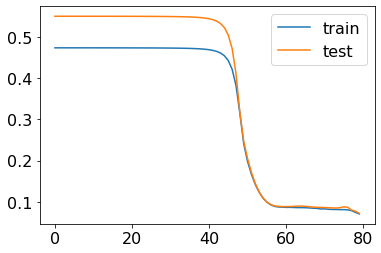

In [370]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Save the Model

In [371]:
RPS_SAVED_MODEL = "rps_saved_model"
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [372]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1, 519)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 500)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [373]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [374]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 1, 519), dtype=tf.float32, name='input_1')})
{'dense_1': TensorSpec(shape=(None, 500), dtype=tf.float32, name='dense_1')}


## Conver Using TFLite's Converter

In [375]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [376]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Download the Converted Model

In [377]:
! zip -r ./rps_saved_model.zip ./rps_saved_model/ 

updating: rps_saved_model/ (stored 0%)
updating: rps_saved_model/assets/ (stored 0%)
updating: rps_saved_model/saved_model.pb (deflated 89%)
updating: rps_saved_model/variables/ (stored 0%)
updating: rps_saved_model/variables/variables.data-00000-of-00001 (deflated 66%)
updating: rps_saved_model/variables/variables.index (deflated 67%)


In [378]:
from google.colab import files
files.download(tflite_model_file)
files.download("rps_saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>